# Segmenting and Clustering Neighborhoods in the city of Chicago

## DESCRIPTION AND METHODOLOGY
In this project, I will be using a slice of a dataset from the portal of the city of Chicago from the year 2001 to 2014 which includes different types of crimes across different blocks (neighborhooods).

This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. 

This dataset is quite large - over 1.5GB in size with over 6.5 million rows. For the purposes of this assignment we will use a much smaller sample of this dataset which can be downloaded from:
https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv

A detailed description of this dataset and the original dataset can be obtained from the Chicago Data Portal at:
https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
I will also utilize the foursquare api to explore the neighborhoods and segment them.

First we download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          92 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0



geopy-1.21.0         | 58 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Sol

In [3]:
# read the data 
df=pd.read_csv('https://ibm.box.com/shared/static/svflyugsr9zbqy5bmowgswqemfpm1x7f.csv')
df.head()

,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,BEAT,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,UPDATEDON,LATITUDE,LONGITUDE,LOCATION
0,3512276,HK587712,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,911,9,14.0,58.0,6,1155838.0,1873050.0,2004,02/10/2018 03:50:01 PM,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,3406613,HK456306,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,820,THEFT,$500 AND UNDER,OTHER,False,False,1112,11,27.0,23.0,6,1152206.0,1906127.0,2004,02/28/2018 03:56:25 PM,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,8002131,HT233595,04/04/2011 05:45:00 AM,043XX S WABASH AVE,820,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,False,False,221,2,3.0,38.0,6,1177436.0,1876313.0,2011,02/10/2018 03:50:01 PM,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,7903289,HT133522,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,423,4,7.0,46.0,6,1194622.0,1850125.0,2010,02/10/2018 03:50:01 PM,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,10402076,HZ138551,02/02/2016 07:30:00 PM,033XX W 66TH ST,820,THEFT,$500 AND UNDER,ALLEY,False,False,831,8,15.0,66.0,6,1155240.0,1860661.0,2016,02/10/2018 03:50:01 PM,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [4]:
# changing the column type
df.DISTRICT = df.DISTRICT.astype(str)

In [7]:
# replacing the column values
df['DISTRICT'] = df['DISTRICT'].str.replace('11', 'HARRISON')

In [8]:
df.head()

,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,BEAT,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,UPDATEDON,LATITUDE,LONGITUDE,LOCATION
0,3512276,HK587712,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,911,9,14.0,58.0,6,1155838.0,1873050.0,2004,02/10/2018 03:50:01 PM,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,3406613,HK456306,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,820,THEFT,$500 AND UNDER,OTHER,False,False,1112,HARRISON,27.0,23.0,6,1152206.0,1906127.0,2004,02/28/2018 03:56:25 PM,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,8002131,HT233595,04/04/2011 05:45:00 AM,043XX S WABASH AVE,820,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,False,False,221,2,3.0,38.0,6,1177436.0,1876313.0,2011,02/10/2018 03:50:01 PM,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,7903289,HT133522,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,423,4,7.0,46.0,6,1194622.0,1850125.0,2010,02/10/2018 03:50:01 PM,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,10402076,HZ138551,02/02/2016 07:30:00 PM,033XX W 66TH ST,820,THEFT,$500 AND UNDER,ALLEY,False,False,831,8,15.0,66.0,6,1155240.0,1860661.0,2016,02/10/2018 03:50:01 PM,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [9]:
# replacing column values with their names
df['DISTRICT'] = df['DISTRICT'].str.replace('2', 'WENTWORTH')
df['DISTRICT'] = df['DISTRICT'].str.replace('3', 'GRAND CROSSING')
df['DISTRICT'] = df['DISTRICT'].str.replace('4', 'SOUTH CHICAGO')
df['DISTRICT'] = df['DISTRICT'].str.replace('5', 'CALUMET')
df['DISTRICT'] = df['DISTRICT'].str.replace('6', 'GRESHAM')
df['DISTRICT'] = df['DISTRICT'].str.replace('7', 'ENGLEWOOD')
df['DISTRICT'] = df['DISTRICT'].str.replace('8', 'CHICAGO LAWN')
df['DISTRICT'] = df['DISTRICT'].str.replace('9', 'DEERING')
df['DISTRICT'] = df['DISTRICT'].str.replace('10', 'OGDEN')
df['DISTRICT'] = df['DISTRICT'].str.replace('12', 'NEAR WEST')
df['DISTRICT'] = df['DISTRICT'].str.replace('14', 'SHAKESPARE')
df['DISTRICT'] = df['DISTRICT'].str.replace('15', 'AUSTIN')
df['DISTRICT'] = df['DISTRICT'].str.replace('16', 'JEFFERSON PARK')
df['DISTRICT'] = df['DISTRICT'].str.replace('17', 'ALBANY PARK')
df['DISTRICT'] = df['DISTRICT'].str.replace('18', 'NEAR NORTH')
df['DISTRICT'] = df['DISTRICT'].str.replace('19', 'TOWN HALL')
df['DISTRICT'] = df['DISTRICT'].str.replace('20', 'LINCOLN')
df['DISTRICT'] = df['DISTRICT'].str.replace('22', 'MORGAN PARK')
df['DISTRICT'] = df['DISTRICT'].str.replace('24', 'ROGERS PARK')
df['DISTRICT'] = df['DISTRICT'].str.replace('25', 'GRAND CENTRAL')

In [10]:
df.head()

,ID,CASE_NUMBER,DATE,BLOCK,IUCR,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,ARREST,DOMESTIC,BEAT,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,FBICODE,X_COORDINATE,Y_COORDINATE,YEAR,UPDATEDON,LATITUDE,LONGITUDE,LOCATION
0,3512276,HK587712,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,False,False,911,DEERING,14.0,58.0,6,1155838.0,1873050.0,2004,02/10/2018 03:50:01 PM,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,3406613,HK456306,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,820,THEFT,$500 AND UNDER,OTHER,False,False,1112,HARRISON,27.0,23.0,6,1152206.0,1906127.0,2004,02/28/2018 03:56:25 PM,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,8002131,HT233595,04/04/2011 05:45:00 AM,043XX S WABASH AVE,820,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,False,False,221,WENTWORTH,3.0,38.0,6,1177436.0,1876313.0,2011,02/10/2018 03:50:01 PM,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,7903289,HT133522,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,423,SOUTH CHICAGO,7.0,46.0,6,1194622.0,1850125.0,2010,02/10/2018 03:50:01 PM,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,10402076,HZ138551,02/02/2016 07:30:00 PM,033XX W 66TH ST,820,THEFT,$500 AND UNDER,ALLEY,False,False,831,CHICAGO LAWN,15.0,66.0,6,1155240.0,1860661.0,2016,02/10/2018 03:50:01 PM,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [11]:
# dropping columns that are not needed
df1 = df.drop(['ID', 'CASE_NUMBER', 'IUCR', 'ARREST', 'DOMESTIC', 'BEAT', 'FBICODE', 'YEAR', 'UPDATEDON'], axis = 1)
df1.head()

,DATE,BLOCK,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,THEFT,FROM BUILDING,SMALL RETAIL STORE,DEERING,14.0,58.0,1155838.0,1873050.0,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,THEFT,$500 AND UNDER,OTHER,HARRISON,27.0,23.0,1152206.0,1906127.0,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,04/04/2011 05:45:00 AM,043XX S WABASH AVE,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,WENTWORTH,3.0,38.0,1177436.0,1876313.0,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,SOUTH CHICAGO,7.0,46.0,1194622.0,1850125.0,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,02/02/2016 07:30:00 PM,033XX W 66TH ST,THEFT,$500 AND UNDER,ALLEY,CHICAGO LAWN,15.0,66.0,1155240.0,1860661.0,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [12]:
# confirming the size of the dataframe
df1.shape

(533, 13)

In [14]:
# renaming columns
df1.rename(columns={'LATITUDE':'Y', 'LONGITUDE':'X'},inplace=True)

In [15]:
df1.head()

,DATE,BLOCK,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION
0,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,THEFT,FROM BUILDING,SMALL RETAIL STORE,DEERING,14.0,58.0,1155838.0,1873050.0,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,THEFT,$500 AND UNDER,OTHER,HARRISON,27.0,23.0,1152206.0,1906127.0,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,04/04/2011 05:45:00 AM,043XX S WABASH AVE,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,WENTWORTH,3.0,38.0,1177436.0,1876313.0,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,SOUTH CHICAGO,7.0,46.0,1194622.0,1850125.0,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,02/02/2016 07:30:00 PM,033XX W 66TH ST,THEFT,$500 AND UNDER,ALLEY,CHICAGO LAWN,15.0,66.0,1155240.0,1860661.0,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [16]:
# dropping null values across the dataframe
df2 = df1.dropna(axis=0, how='any')

In [17]:
# checking the size of the resulting dataframe
df2.shape

(487, 13)

In [18]:
# getting an analysis of the dataframe
df2.describe(include=['object'])

,DATE,BLOCK,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,DISTRICT,LOCATION
count,487,487,487,487,487,487,487
unique,486,474,34,95,45,22,483
top,03/02/2009 09:10:00 PM,100XX W OHARE ST,THEFT,SIMPLE,STREET,HARRISON,"(41.754592961, -87.741528537)"
freq,2,2,100,49,128,44,2


In [19]:
df2.head()

,DATE,BLOCK,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION
0,08/28/2004 05:50:56 PM,047XX S KEDZIE AVE,THEFT,FROM BUILDING,SMALL RETAIL STORE,DEERING,14.0,58.0,1155838.0,1873050.0,41.807441,-87.703956,"(41.8074405, -87.703955849)"
1,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,THEFT,$500 AND UNDER,OTHER,HARRISON,27.0,23.0,1152206.0,1906127.0,41.898280,-87.716406,"(41.898279962, -87.716405505)"
2,04/04/2011 05:45:00 AM,043XX S WABASH AVE,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,WENTWORTH,3.0,38.0,1177436.0,1876313.0,41.815933,-87.624642,"(41.815933131, -87.624642127)"
3,12/30/2010 04:30:00 PM,083XX S KINGSTON AVE,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,SOUTH CHICAGO,7.0,46.0,1194622.0,1850125.0,41.743665,-87.562463,"(41.743665322, -87.562462756)"
4,02/02/2016 07:30:00 PM,033XX W 66TH ST,THEFT,$500 AND UNDER,ALLEY,CHICAGO LAWN,15.0,66.0,1155240.0,1860661.0,41.773455,-87.706480,"(41.773455295, -87.706480471)"


In [53]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


Text(0.5, 0, 'Frequency of Incidences')

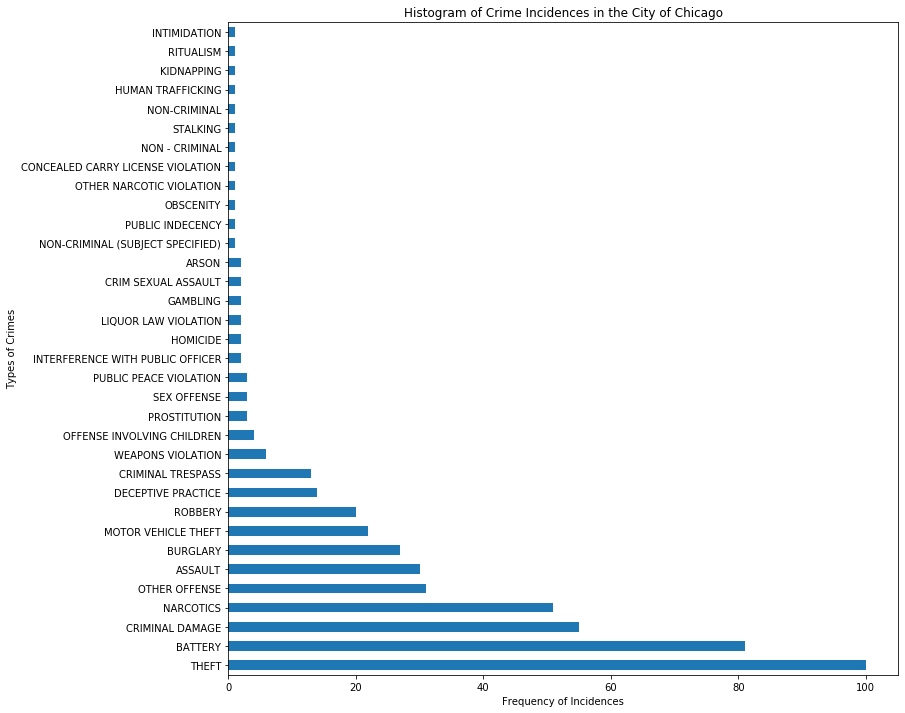

In [21]:
# generating a plot of the types of crime to visually determine the frequencies of the crimes recorded
ax = df2.PRIMARY_TYPE.value_counts().plot.barh(figsize=(12, 12))
ax.set_facecolor('white')
ax.set_title('Histogram of Crime Incidences in the City of Chicago') # add a title to the histogram
ax.set_ylabel('Types of Crimes') # add y-label
ax.set_xlabel('Frequency of Incidences') # add x-label

The plot shows that THEFT is the most common of the crimes with a frequency of 100.

We begin generating maps of Chicago

In [23]:
# Chicago latitude and longitude values
latitude = 41.881832
longitude = -87.623177

In [24]:
# create map and display it
chicago_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# display the map of Chicago
chicago_map

Adding some pop-up text that would get displayed when you hover over a marker. Let's make each marker display the category of the crime when hovered over.

In [25]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(df2.Y, df2.X):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
chicago_map.add_child(incidents)

Here I superimpose the locations of the crimes onto the map. Doing that in **Folium** I create a *feature group* with its own features and style and then add it to the chicago_map.

In [27]:
from folium import plugins

# let's start again with a clean copy of the map of Chicago
chicago_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(chicago_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df2.Y, df2.X, df2.PRIMARY_TYPE):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)
# display map
chicago_map

#### Creating a map of Chicago with neighborhoods superimposed on top.

In [28]:
# create map of New York using latitude and longitude values
chicago_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, DISTRICT, BLOCK in zip(df2['Y'], df2['X'], df2['DISTRICT'], df2['BLOCK']):
    label = '{}, {}'.format(BLOCK, DISTRICT)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chicago_map)  
    
chicago_map

For illustration purposes, I simplify the above map and segment and cluster only the neighborhoods in Harrison. So I slice the original dataframe and create a new dataframe of the Harrison data.

In [32]:
district_data = df2[df2['DISTRICT'] == 'HARRISON'].reset_index(drop=True)
district_data.head()

,DATE,BLOCK,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION
0,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,THEFT,$500 AND UNDER,OTHER,HARRISON,27.0,23.0,1152206.0,1906127.0,41.898280,-87.716406,"(41.898279962, -87.716405505)"
1,01/05/2003 06:30:00 PM,038XX W FLOURNOY ST,THEFT,FROM BUILDING,RESIDENCE PORCH/HALLWAY,HARRISON,24.0,26.0,1150808.0,1896753.0,41.872584,-87.721786,"(41.872584178, -87.72178565)"
2,08/31/2017 03:30:00 AM,011XX N KARLOV AVE,THEFT,OVER $500,RESIDENTIAL YARD (FRONT/BACK),HARRISON,37.0,23.0,1148843.0,1907272.0,41.901488,-87.728728,"(41.901487656, -87.728728004)"
3,11/03/2004 10:00:00 AM,008XX N KEDZIE AVE,THEFT,$500 AND UNDER,STREET,HARRISON,27.0,23.0,1154891.0,1905271.0,41.895878,-87.706567,"(41.895877613, -87.706566627)"
4,07/12/2005 11:00:00 PM,008XX N CICERO AVE,THEFT,$500 AND UNDER,GAS STATION,HARRISON,37.0,25.0,1144207.0,1904963.0,41.895240,-87.745815,"(41.895239896, -87.745814792)"


In [30]:
# Harrison latitude and longitude values
latitude = 41.881832
longitude = -87.623177

Visualizing the Harrison District.

In [33]:
# create map of Harrison using latitude and longitude values
map_harrison = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(district_data['Y'], district_data['X'], district_data['BLOCK']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_harrison)  
    
map_harrison

Next, I am going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
#### Define Foursquare Credentials and Version

In [42]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


#### Exploring the first neighborhood in the dataframe.
Get the neighborhood's name.

In [35]:
district_data.loc[0, 'BLOCK']

'009XX N CENTRAL PARK AVE'

Getting the neighborhood's latitude and longitude values.

In [81]:
neighborhood_latitude = district_data.loc[0, 'Y'] # neighborhood latitude value
neighborhood_longitude = district_data.loc[0, 'X'] # neighborhood longitude value

neighborhood_name = district_data.loc[0, 'BLOCK'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 009XX N CENTRAL PARK AVE are 41.89827996, -87.71640551.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.
Creating a GET request URL.

In [ ]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

Sending the GET request and examining the resutls

In [83]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eba9cd1a2e538001b704e39'},
 'response': {'headerLocation': 'Humboldt Park',
  'headerFullLocation': 'Humboldt Park, Chicago',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 12,
  'suggestedBounds': {'ne': {'lat': 41.902779964500006,
    'lng': -87.7103710993824},
   'sw': {'lat': 41.8937799555, 'lng': -87.7224399206176}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51537020e4b0bdbdf0385bf3',
       'name': 'Turkey Chop',
       'location': {'address': '3506 W Chicago Ave',
        'crossStreet': 'at N St. Louis Ave',
        'lat': 41.8956583765066,
        'lng': -87.71428132829729,
        'labeledLatLngs': [{'label': 'display',
          'lat': 41.8956583765066,
          'lng': -87.71428132829729},
         

Borrowing the **get_category_type** function from the Foursquare lab.

In [84]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Cleaning the json and structuring it into a *pandas* dataframe.

In [85]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Turkey Chop,American Restaurant,41.895658,-87.714281
1,Central Park Produce,Grocery Store,41.902556,-87.716790
2,Redbox,Video Store,41.901863,-87.714646
3,Dunkin',Donut Shop,41.902367,-87.717046
4,Whale Fish Shrimp & Chicken,Seafood Restaurant,41.895732,-87.716510


In [86]:
# checking the number of venues returned by foursquare
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

12 venues were returned by Foursquare.


## Exploring Neighborhoods in Harrison
#### Creating a function to repeat the same process to all the neighborhoods in Harrison

In [87]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Creating a new dataframe called *Harrison_venues*.

In [88]:
Harrison_venues = getNearbyVenues(names=district_data['BLOCK'],
                                   latitudes=district_data['Y'],
                                   longitudes=district_data['X']
                                  )

009XX N CENTRAL PARK AVE
038XX W FLOURNOY ST
011XX N KARLOV AVE
008XX N KEDZIE AVE
008XX N CICERO AVE
025XX W FLOURNOY ST
033XX W MAYPOLE AVE
009XX N CENTRAL PARK AVE
047XX W SUPERIOR ST
007XX N LAWNDALE AVE
030XX W JACKSON BLVD
038XX W FILLMORE ST
008XX S SPRINGFIELD AVE
010XX N KEYSTONE AVE
003XX S MOZART ST
003XX N PULASKI RD
039XX W GLADYS AVE
002XX S WHIPPLE ST
047XX W FULTON ST
003XX S WESTERN AVE
040XX W WILCOX ST
033XX W FILLMORE ST
031XX W FIFTH AVE
008XX N HOMAN AVE
039XX W LEXINGTON ST
008XX N KEELER AVE
006XX N RIDGEWAY AVE
009XX N HAMLIN AVE
035XX W GRAND AVE
011XX N PULASKI RD
007XX S KENNETH AVE
011XX N KEYSTONE AVE
028XX W ARTHINGTON ST
038XX W MONROE ST
032XX W ADAMS ST
001XX N KARLOV AVE
036XX W ROOSEVELT RD
043XX W WALTON ST
036XX W DIVISION ST
041XX W GLADYS AVE
003XX S MAPLEWOOD AVE
0000X N KENTON AVE
031XX W FLOURNOY ST
009XX N KARLOV AVE


#### Checking the size of the resulting dataframe

In [89]:
print(Harrison_venues.shape)
Harrison_venues.head()

(432, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,009XX N CENTRAL PARK AVE,41.89828,-87.716406,Turkey Chop,41.895658,-87.714281,American Restaurant
1,009XX N CENTRAL PARK AVE,41.89828,-87.716406,Central Park Produce,41.902556,-87.716790,Grocery Store
2,009XX N CENTRAL PARK AVE,41.89828,-87.716406,Redbox,41.901863,-87.714646,Video Store
3,009XX N CENTRAL PARK AVE,41.89828,-87.716406,Dunkin',41.902367,-87.717046,Donut Shop
4,009XX N CENTRAL PARK AVE,41.89828,-87.716406,Whale Fish Shrimp & Chicken,41.895732,-87.716510,Seafood Restaurant


Let's check how many venues were returned for each neighborhood

In [91]:
Harrison_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
0000X N KENTON AVE,5,5,5,5,5,5
001XX N KARLOV AVE,19,19,19,19,19,19
002XX S WHIPPLE ST,9,9,9,9,9,9
003XX N PULASKI RD,8,8,8,8,8,8
003XX S MAPLEWOOD AVE,11,11,11,11,11,11
003XX S MOZART ST,6,6,6,6,6,6
003XX S WESTERN AVE,20,20,20,20,20,20
006XX N RIDGEWAY AVE,7,7,7,7,7,7
007XX N LAWNDALE AVE,4,4,4,4,4,4


#### Checking out many unique categories can be curated from all the returned venues

In [92]:
print('There are {} uniques categories.'.format(len(Harrison_venues['Venue Category'].unique())))

There are 81 uniques categories.


## Analyzing Each Neighborhood

In [93]:
# one hot encoding
harrison_onehot = pd.get_dummies(Harrison_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
harrison_onehot['Neighborhood'] = Harrison_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [harrison_onehot.columns[-1]] + list(harrison_onehot.columns[:-1])
harrison_onehot = harrison_onehot[fixed_columns]

harrison_onehot.head()

,Neighborhood,ATM,African Restaurant,American Restaurant,Art Gallery,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Boutique,Burrito Place,Bus Line,Bus Station,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Deli / Bodega,Diner,Discount Store,Donut Shop,Fast Food Restaurant,Food,Food & Drink Shop,Football Stadium,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Grocery Store,Hockey Arena,Hot Dog Joint,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Locksmith,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Music Venue,Optical Shop,Park,Pharmacy,Photography Studio,Pizza Place,Print Shop,Record Shop,Recreation Center,Sandwich Place,Seafood Restaurant,Shoe Store,Skating Rink,Social Club,Southern / Soul Food Restaurant,Sporting Goods Shop,Sports Bar,Supermarket,Taco Place,Theater,Train Station,Vacation Rental,Video Game Store,Video Store,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,009XX N CENTRAL PARK AVE,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,009XX N CENTRAL PARK AVE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,009XX N CENTRAL PARK AVE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,009XX N CENTRAL PARK AVE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,009XX N CENTRAL PARK AVE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
# Checking the size of the dataframe
harrison_onehot.shape

(432, 82)

#### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [95]:
harrison_grouped = harrison_onehot.groupby('Neighborhood').mean().reset_index()
harrison_grouped

,Neighborhood,ATM,African Restaurant,American Restaurant,Art Gallery,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Basketball Court,Boutique,Burrito Place,Bus Line,Bus Station,Business Service,Café,Caribbean Restaurant,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Deli / Bodega,Diner,Discount Store,Donut Shop,Fast Food Restaurant,Food,Food & Drink Shop,Football Stadium,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Grocery Store,Hockey Arena,Hot Dog Joint,Ice Cream Shop,Intersection,Italian Restaurant,Japanese Restaurant,Kids Store,Korean Restaurant,Latin American Restaurant,Liquor Store,Locksmith,Middle Eastern Restaurant,Mobile Phone Shop,Movie Theater,Music Venue,Optical Shop,Park,Pharmacy,Photography Studio,Pizza Place,Print Shop,Record Shop,Recreation Center,Sandwich Place,Seafood Restaurant,Shoe Store,Skating Rink,Social Club,Southern / Soul Food Restaurant,Sporting Goods Shop,Sports Bar,Supermarket,Taco Place,Theater,Train Station,Vacation Rental,Video Game Store,Video Store,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,0000X N KENTON AVE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.200000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.0,0.000000,0.00,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,001XX N KARLOV AVE,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052632,0.000000,0.000,0.00,0.000000,0.000000,0.000,0.000000,0.052632,0.000000,0.210526,0.000000,0.00,0.000000,0.105263,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.052632,0.000000,0.052632,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.052632,0.00,0.0,0.000000,0.105263,0.000000,0.157895,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,002XX S WHIPPLE ST,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000,0.222222,0.111111,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.111111,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.111111,0.000000,0.000000,0.111111,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,003XX N PULASKI RD,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.125,0.00,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.125000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.125000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,003XX S MAPLEWOOD AVE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.0,0.0

In [96]:
# checking the size of the dataframe
harrison_grouped.shape

(43, 82)

#### Printing each neighborhood along with the top 5 most common venues

In [97]:
num_top_venues = 5

for hood in harrison_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = harrison_grouped[harrison_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0000X N KENTON AVE----
                  venue  freq
0  Fast Food Restaurant   0.2
1                Church   0.2
2           Social Club   0.2
3          Optical Shop   0.2
4           Record Shop   0.2


----001XX N KARLOV AVE----
                  venue  freq
0  Fast Food Restaurant  0.21
1            Shoe Store  0.16
2        Sandwich Place  0.11
3   Fried Chicken Joint  0.11
4              Boutique  0.05


----002XX S WHIPPLE ST----
                 venue  freq
0                Diner  0.22
1        Hot Dog Joint  0.11
2             Bus Line  0.11
3  American Restaurant  0.11
4       Discount Store  0.11


----003XX N PULASKI RD----
                  venue  freq
0         Train Station  0.25
1                   ATM  0.12
2        Sandwich Place  0.12
3         Deli / Bodega  0.12
4  Fast Food Restaurant  0.12


----003XX S MAPLEWOOD AVE----
                  venue  freq
0  Fast Food Restaurant  0.18
1                  Park  0.18
2          Hockey Arena  0.09
3                   

#### Putting that into a *pandas* dataframe

Sorting the venues in descending order.

In [98]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a new dataframe and displaying the top 10 venues for each neighborhood.

In [99]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = harrison_grouped['Neighborhood']

for ind in np.arange(harrison_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(harrison_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0000X N KENTON AVE,Church,Record Shop,Optical Shop,Fast Food Restaurant,Social Club,Deli / Bodega,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop
1,001XX N KARLOV AVE,Fast Food Restaurant,Shoe Store,Fried Chicken Joint,Sandwich Place,ATM,Discount Store,Pizza Place,Middle Eastern Restaurant,Liquor Store,Boutique
2,002XX S WHIPPLE ST,Diner,Hot Dog Joint,Supermarket,Bus Line,Southern / Soul Food Restaurant,Discount Store,Pharmacy,American Restaurant,Food & Drink Shop,Food
3,003XX N PULASKI RD,Train Station,ATM,Boutique,Coffee Shop,Sandwich Place,Fast Food Restaurant,Deli / Bodega,Cocktail Bar,Convenience Store,Cosmetics Shop
4,003XX S MAPLEWOOD AVE,Park,Fast Food Restaurant,Train Station,Chinese Restaurant,Bus Station,Basketball Court,Bar,Hockey Arena,Boutique,Food & Drink Shop


In [102]:
# renaming the neighborhood column
neighborhoods_venues_sorted.rename(columns={'Neighborhood':'BLOCK'},inplace=True)

In [103]:
neighborhoods_venues_sorted.head()

,CLabel,BLOCK,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,0000X N KENTON AVE,Church,Record Shop,Optical Shop,Fast Food Restaurant,Social Club,Deli / Bodega,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop
1,2,001XX N KARLOV AVE,Fast Food Restaurant,Shoe Store,Fried Chicken Joint,Sandwich Place,ATM,Discount Store,Pizza Place,Middle Eastern Restaurant,Liquor Store,Boutique
2,4,002XX S WHIPPLE ST,Diner,Hot Dog Joint,Supermarket,Bus Line,Southern / Soul Food Restaurant,Discount Store,Pharmacy,American Restaurant,Food & Drink Shop,Food
3,2,003XX N PULASKI RD,Train Station,ATM,Boutique,Coffee Shop,Sandwich Place,Fast Food Restaurant,Deli / Bodega,Cocktail Bar,Convenience Store,Cosmetics Shop
4,2,003XX S MAPLEWOOD AVE,Park,Fast Food Restaurant,Train Station,Chinese Restaurant,Bus Station,Basketball Court,Bar,Hockey Arena,Boutique,Food & Drink Shop


In [ ]:
neighborhoods_venues_sorted.head()

## Cluster Neighborhoods

Running *k*-means to cluster the neighborhood into 5 clusters.

In [104]:
# set number of clusters
kclusters = 5

harrison_grouped_clustering = harrison_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(harrison_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 4, 2, 2, 1, 2, 1, 1, 1], dtype=int32)

Creating a new dataframe that includes the clusters as well as the top 10 venues for each neighborhood.

In [105]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'CULabel', kmeans.labels_)

harrison_merged = district_data

# merge harrison_grouped with Harrison_data to add latitude/longitude for each neighborhood
harrison_merged = harrison_merged.join(neighborhoods_venues_sorted.set_index('BLOCK'), on='BLOCK')

harrison_merged.head() # check the last columns!

,DATE,BLOCK,PRIMARY_TYPE,DESCRIPTION,LOCATION_DESCRIPTION,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION,CULabel,CLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,06/26/2004 12:40:00 PM,009XX N CENTRAL PARK AVE,THEFT,$500 AND UNDER,OTHER,HARRISON,27.0,23.0,1152206.0,1906127.0,41.898280,-87.716406,"(41.898279962, -87.716405505)",1,1,Park,Music Venue,Grocery Store,American Restaurant,Video Store,Recreation Center,Fast Food Restaurant,Donut Shop,Seafood Restaurant,Liquor Store
1,01/05/2003 06:30:00 PM,038XX W FLOURNOY ST,THEFT,FROM BUILDING,RESIDENCE PORCH/HALLWAY,HARRISON,24.0,26.0,1150808.0,1896753.0,41.872584,-87.721786,"(41.872584178, -87.72178565)",2,2,Fast Food Restaurant,Grocery Store,BBQ Joint,Bakery,Train Station,Café,Seafood Restaurant,Discount Store,Convenience Store,Cosmetics Shop
2,08/31/2017 03:30:00 AM,011XX N KARLOV AVE,THEFT,OVER $500,RESIDENTIAL YARD (FRONT/BACK),HARRISON,37.0,23.0,1148843.0,1907272.0,41.901488,-87.728728,"(41.901487656, -87.728728004)",1,1,Convenience Store,Park,Food & Drink Shop,Latin American Restaurant,Yoga Studio,Discount Store,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega
3,11/03/2004 10:00:00 AM,008XX N KEDZIE AVE,THEFT,$500 AND UNDER,STREET,HARRISON,27.0,23.0,1154891.0,1905271.0,41.895878,-87.706567,"(41.895877613, -87.706566627)",2,2,Shoe Store,Sandwich Place,Grocery Store,Clothing Store,Chinese Restaurant,Bus Line,Bus Station,Pizza Place,Park,Yoga Studio
4,07/12/2005 11:00:00 PM,008XX N CICERO AVE,THEFT,$500 AND UNDER,GAS STATION,HARRISON,37.0,25.0,1144207.0,1904963.0,41.895240,-87.745815,"(41.895239896, -87.745814792)",2,2,Clothing Store,African Restaurant,BBQ Joint,Chinese Restaurant,Currency Exchange,Food,Discount Store,Coffee Shop,Convenience Store,Cosmetics Shop


Visualizing the resulting clusters

In [109]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(harrison_merged['Y'], harrison_merged['X'], harrison_merged['BLOCK'], harrison_merged['CULabel']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examining Clusters

## Residential Area

In [117]:
H1 = harrison_merged.loc[harrison_merged['CULabel'] == 0, harrison_merged.columns[[1] + list(range(5, harrison_merged.shape[1]))]]
H1

,BLOCK,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION,CULabel,CLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,010XX N KEYSTONE AVE,HARRISON,37.0,23.0,1149197.0,1906636.0,41.899736,-87.727444,"(41.899735553, -87.727444212)",0,0,Gas Station,Wings Joint,Park,Convenience Store,Food & Drink Shop,Diner,Cocktail Bar,Coffee Shop,Cosmetics Shop,Currency Exchange
25,008XX N KEELER AVE,HARRISON,37.0,23.0,1148227.0,1905349.0,41.896223,-87.731040,"(41.896222633, -87.731040246)",0,0,Fast Food Restaurant,Wings Joint,Gas Station,Convenience Store,Bus Station,Discount Store,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega
27,009XX N HAMLIN AVE,HARRISON,27.0,23.0,1150883.0,1905924.0,41.897749,-87.721270,"(41.897748913, -87.721270135)",0,0,Gas Station,Wings Joint,Recreation Center,Seafood Restaurant,Food,Fast Food Restaurant,Deli / Bodega,Cocktail Bar,Coffee Shop,Convenience Store
31,011XX N KEYSTONE AVE,HARRISON,27.0,23.0,1149178.0,1907288.0,41.901525,-87.727497,"(41.901525076, -87.727497088)",0,0,Donut Shop,Gas Station,Convenience Store,Latin American Restaurant,Discount Store,Yoga Studio,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega
43,009XX N KARLOV AVE,HARRISON,37.0,23.0,1148881.0,1905963.0,41.897895,-87.728622,"(41.89789489, -87.728622316)",0,0,Fast Food Restaurant,Wings Joint,Gas Station,Convenience Store,Discount Store,Cocktail Bar,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega


In [142]:
H1.describe(include=['object'])

,BLOCK,DISTRICT,LOCATION,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,5,5,5,5,5,5,5,5,5,5,5,5,5
unique,5,1,5,3,2,4,3,4,5,3,3,3,3
top,009XX N HAMLIN AVE,HARRISON,"(41.899735553, -87.727444212)",Fast Food Restaurant,Wings Joint,Gas Station,Convenience Store,Discount Store,Fast Food Restaurant,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega
freq,1,5,1,2,4,2,3,2,1,3,3,3,3


#### From this cluster above we can see the most frequent venues and categorize them into Restaurants, Convenience stores, Gas station and Currency Exchange 

## Recreational Area

In [118]:
H2 =harrison_merged.loc[harrison_merged['CULabel'] == 1, harrison_merged.columns[[1] + list(range(5, harrison_merged.shape[1]))]]
H2

,BLOCK,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION,CULabel,CLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,009XX N CENTRAL PARK AVE,HARRISON,27.0,23.0,1152206.0,1906127.0,41.898280,-87.716406,"(41.898279962, -87.716405505)",1,1,Park,Music Venue,Grocery Store,American Restaurant,Video Store,Recreation Center,Fast Food Restaurant,Donut Shop,Seafood Restaurant,Liquor Store
2,011XX N KARLOV AVE,HARRISON,37.0,23.0,1148843.0,1907272.0,41.901488,-87.728728,"(41.901487656, -87.728728004)",1,1,Convenience Store,Park,Food & Drink Shop,Latin American Restaurant,Yoga Studio,Discount Store,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega
5,025XX W FLOURNOY ST,HARRISON,2.0,28.0,1159336.0,1896944.0,41.872937,-87.690470,"(41.872937304, -87.690470166)",1,1,Park,Hot Dog Joint,Train Station,Middle Eastern Restaurant,Bus Station,Photography Studio,Basketball Court,Italian Restaurant,Food,Fast Food Restaurant
7,009XX N CENTRAL PARK AVE,HARRISON,27.0,23.0,1152207.0,1906086.0,41.898167,-87.716403,"(41.898167434, -87.716402915)",1,1,Park,Music Venue,Grocery Store,American Restaurant,Video Store,Recreation Center,Fast Food Restaurant,Donut Shop,Seafood Restaurant,Liquor Store
9,007XX N LAWNDALE AVE,HARRISON,27.0,23.0,1151588.0,1904632.0,41.894190,-87.718715,"(41.894189705, -87.718714722)",1,1,Park,American Restaurant,Recreation Center,Seafood Restaurant,Yoga Studio,Diner,Coffee Shop,Convenience Store,Cosmetics Shop,Currency Exchange
14,003XX S MOZART ST,HARRISON,2.0,27.0,1157437.0,1898367.0,41.876881,-87.697404,"(41.876880974, -87.697403598)",1,1,Hot Dog Joint,American Restaurant,Park,Seafood Restaurant,Food,Mobile Phone Shop,Diner,Coffee Shop,Convenience Store,Cosmetics Shop
18,047XX W FULTON ST,HARRISON,28.0,25.0,1144810.0,1901373.0,41.885377,-87.743691,"(41.88537717, -87.743690705)",1,1,Liquor Store,Donut Shop,Deli / Bodega,Yoga Studio,Coffee Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Diner,Discount Store
26,006XX N RIDGEWAY AVE,HARRISON,27.0,23.0,1151272.0,1904037.0,41.892563,-87.719891,"(41.89256317, -87.719890923)",1,1,Cocktail Bar,Park,Art Gallery,Recreation Center,Seafood Restaurant,Japanese Restaurant,Korean Restaurant,Diner,Coffee Shop,Convenience Store
28,035XX W GRAND AVE,HARRISON,26.0,23.0,1152431.0,1907428.0,41.901846,-87.715545,"(41.901845588, -87.715544681)",1,1,Donut Shop,Grocery Store,Video Store,Art Gallery,Sandwich Place,Fast Food Restaurant,Liquor Store,Diner,Coffee Shop,Convenience Store
29,011XX N PULASKI RD,HARRISON,27.0,23.0,1149510.0,1907365.0,41.901730,-87.726276,"(41.901729932, -87.726275604)",1,1,Donut Shop,Gas Station,Latin American Restaurant,Discount Store,Yoga Studio,Coffee Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Deli / Bodega


In [143]:
H2.describe(include=['object'])

,BLOCK,DISTRICT,LOCATION,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,14,14,14,14,14,14,14,14,14,14,14,14,14
unique,13,1,14,10,8,11,10,11,11,9,8,8,8
top,009XX N CENTRAL PARK AVE,HARRISON,"(41.89256317, -87.719890923)",Park,American Restaurant,Video Store,Seafood Restaurant,Yoga Studio,Coffee Shop,Coffee Shop,Cosmetics Shop,Currency Exchange,Deli / Bodega
freq,2,14,1,4,3,2,2,3,3,3,4,4,4


#### The cluster above shows the most frequent venues and using the descriptive statistics we can categorize them into Restaurants, Park, Video Shop, Yoga Studio, Cosmetic Shop and Currency Exchange. 

## Residential Area

In [119]:
H3 = harrison_merged.loc[harrison_merged['CULabel'] == 2, harrison_merged.columns[[1] + list(range(5, harrison_merged.shape[1]))]]
H3

,BLOCK,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION,CULabel,CLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,038XX W FLOURNOY ST,HARRISON,24.0,26.0,1150808.0,1896753.0,41.872584,-87.721786,"(41.872584178, -87.72178565)",2,2,Fast Food Restaurant,Grocery Store,BBQ Joint,Bakery,Train Station,Café,Seafood Restaurant,Discount Store,Convenience Store,Cosmetics Shop
3,008XX N KEDZIE AVE,HARRISON,27.0,23.0,1154891.0,1905271.0,41.895878,-87.706567,"(41.895877613, -87.706566627)",2,2,Shoe Store,Sandwich Place,Grocery Store,Clothing Store,Chinese Restaurant,Bus Line,Bus Station,Pizza Place,Park,Yoga Studio
4,008XX N CICERO AVE,HARRISON,37.0,25.0,1144207.0,1904963.0,41.895240,-87.745815,"(41.895239896, -87.745814792)",2,2,Clothing Store,African Restaurant,BBQ Joint,Chinese Restaurant,Currency Exchange,Food,Discount Store,Coffee Shop,Convenience Store,Cosmetics Shop
8,047XX W SUPERIOR ST,HARRISON,28.0,25.0,1144674.0,1904545.0,41.894084,-87.744110,"(41.894084068, -87.744110141)",2,2,Clothing Store,African Restaurant,BBQ Joint,Chinese Restaurant,Currency Exchange,Food,Discount Store,Coffee Shop,Convenience Store,Cosmetics Shop
11,038XX W FILLMORE ST,HARRISON,24.0,29.0,1151050.0,1895100.0,41.868043,-87.720940,"(41.868043424, -87.720940449)",2,2,Fried Chicken Joint,Sandwich Place,American Restaurant,Cosmetics Shop,Bakery,Fast Food Restaurant,Mobile Phone Shop,Burrito Place,Yoga Studio,Diner
12,008XX S SPRINGFIELD AVE,HARRISON,24.0,26.0,1150520.0,1895862.0,41.870145,-87.722866,"(41.870144798, -87.7228663)",2,2,Fast Food Restaurant,Sandwich Place,American Restaurant,Fried Chicken Joint,BBQ Joint,Bakery,Train Station,Cosmetics Shop,Mobile Phone Shop,Café
15,003XX N PULASKI RD,HARRISON,28.0,26.0,1149673.0,1901704.0,41.886192,-87.725824,"(41.886192389, -87.725824111)",2,2,Train Station,ATM,Boutique,Coffee Shop,Sandwich Place,Fast Food Restaurant,Deli / Bodega,Cocktail Bar,Convenience Store,Cosmetics Shop
16,039XX W GLADYS AVE,HARRISON,24.0,26.0,1150166.0,1898065.0,41.876197,-87.724109,"(41.876196982, -87.724108549)",2,2,Fast Food Restaurant,Park,Taco Place,Middle Eastern Restaurant,Café,Clothing Store,Sporting Goods Shop,Caribbean Restaurant,Intersection,Seafood Restaurant
19,003XX S WESTERN AVE,HARRISON,2.0,28.0,1160452.0,1898418.0,41.876959,-87.686332,"(41.876959088, -87.686332007)",2,2,Sandwich Place,Park,Fast Food Restaurant,Chinese Restaurant,Bus Station,Pizza Place,Café,Bus Line,Boutique,Grocery Store
20,040XX W WILCOX ST,HARRISON,28.0,26.0,1149571.0,1899032.0,41.878862,-87.726268,"(41.878862107, -87.726268091)",2,2,Fast Food Restaurant,Shoe Store,Clothing Store,Caribbean Restaurant,Grocery Store,Intersection,Kids Store,Cosmetics Shop,Convenience Store,Middle Eastern Restaurant


In [144]:
H3.describe(include=['object'])

,BLOCK,DISTRICT,LOCATION,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,19,19,19,19,19,19,19,19,19,19,19,19,19
unique,19,1,19,9,11,13,14,14,16,16,13,11,13
top,0000X N KENTON AVE,HARRISON,"(41.896834618, -87.711479159)",Fast Food Restaurant,Sandwich Place,BBQ Joint,Chinese Restaurant,Currency Exchange,Fast Food Restaurant,Seafood Restaurant,Coffee Shop,Convenience Store,Cosmetics Shop
freq,1,19,1,8,4,4,4,2,2,2,3,7,6


#### The cluster above shows the most frequent venues and using the descriptive statistics we can categorize them into Restaurants, Convenience store and Currency Exchange.

## Residential Area

In [115]:
harrison_merged.loc[harrison_merged['CULabel'] == 3, harrison_merged.columns[[1] + list(range(5, harrison_merged.shape[1]))]]

,BLOCK,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION,CULabel,CLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,028XX W ARTHINGTON ST,HARRISON,2.0,27.0,1157555.0,1895912.0,41.870142,-87.697037,"(41.87014181, -87.697037158)",3,3,Park,Yoga Studio,Clothing Store,Coffee Shop,Convenience Store,Cosmetics Shop,Currency Exchange,Deli / Bodega,Diner,Discount Store


#### This cluster might be an outlier as it only has one record and thus cannot be used to determine the relation of the dataset to the neighborhoods

## City Area

In [120]:
H5 = harrison_merged.loc[harrison_merged['CULabel'] == 4, harrison_merged.columns[[1] + list(range(5, harrison_merged.shape[1]))]]
H5

,BLOCK,DISTRICT,WARD,COMMUNITY_AREA_NUMBER,X_COORDINATE,Y_COORDINATE,Y,X,LOCATION,CULabel,CLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,033XX W MAYPOLE AVE,HARRISON,28.0,27.0,1154131.0,1900784.0,41.883580,-87.709478,"(41.883580046, -87.709477772)",4,4,Food,Discount Store,Train Station,Business Service,Liquor Store,Diner,Pharmacy,Park,Vacation Rental,Warehouse Store
10,030XX W JACKSON BLVD,HARRISON,28.0,27.0,1156002.0,1898529.0,41.877355,-87.702668,"(41.877354573, -87.702668131)",4,4,Diner,American Restaurant,Pharmacy,Discount Store,Supermarket,Bus Line,Skating Rink,Liquor Store,Southern / Soul Food Restaurant,Hot Dog Joint
17,002XX S WHIPPLE ST,HARRISON,28.0,27.0,1156082.0,1898741.0,41.877935,-87.702369,"(41.877934709, -87.702368669)",4,4,Diner,Hot Dog Joint,Supermarket,Bus Line,Southern / Soul Food Restaurant,Discount Store,Pharmacy,American Restaurant,Food & Drink Shop,Food
22,031XX W FIFTH AVE,HARRISON,28.0,27.0,1155247.0,1898955.0,41.878539,-87.705429,"(41.878538751, -87.705428851)",4,4,Diner,Discount Store,Supermarket,Bus Station,Bus Line,Southern / Soul Food Restaurant,Pharmacy,Football Stadium,Food,Fast Food Restaurant
34,032XX W ADAMS ST,HARRISON,28.0,27.0,1154752.0,1898890.0,41.878370,-87.707248,"(41.878370307, -87.707248137)",4,4,Discount Store,Pharmacy,Diner,Football Stadium,Food,Train Station,Bus Station,Supermarket,Southern / Soul Food Restaurant,Bus Line


In [145]:
H5.describe(include=['object'])

,BLOCK,DISTRICT,LOCATION,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,5,5,5,5,5,5,5,5,5,5,5,5,5
unique,5,1,5,3,4,4,5,5,5,3,5,4,5
top,033XX W MAYPOLE AVE,HARRISON,"(41.878370307, -87.707248137)",Diner,Discount Store,Supermarket,Business Service,Supermarket,Train Station,Pharmacy,Football Stadium,Southern / Soul Food Restaurant,Fast Food Restaurant
freq,1,5,1,3,2,2,1,1,1,3,1,2,1


#### The cluster above shows the most frequent venues and using the descriptive statistics we can categorize them into Supermarket, Diner, Discount store, Business services, Train services, Stadium and Restaurants.

## Results
After clustering the data of the respective neighborhoods, we notice that the neighborhoods have a lot of public places that light crimes like theft can easily take place. From the clusters we can also notice that one place common in all clusters are restaurants and restaurants indicate that there will generally be an influx of different people coming to these areas to get something to eat. This can lead to increase in crime as criminal activities are usually common where there is high population density.

## Conclusion
The results have shown what type of crime is more prominent and why therefore as people go about their normal day life they should be very security conscious as theft is a common crime in the Harrison district of the City of Chicago. To this end, we implore the Chicago Police Department to utilize this result and implement better policing methods to reduce to a minimum the high incidence of crime in the Harrison district of the the City of Chicago.